In [58]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader, IterableDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.distributions.dirichlet import Dirichlet
from itertools import groupby
import random

Taken from here: https://www.kaggle.com/code/puru98/federated-learning-pytorch

In [59]:
#Download data
train_dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [60]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 20
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [61]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [62]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [63]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [64]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size, opt=torch.optim.SGD)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [65]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

## Simple SGD:

In [66]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.5018, Accuracy = 0.8449
client_1: Loss = 0.4689, Accuracy = 0.8552
client_2: Loss = 0.4682, Accuracy = 0.8574
client_3: Loss = 0.482, Accuracy = 0.848
client_4: Loss = 0.4966, Accuracy = 0.8478
client_5: Loss = 0.4781, Accuracy = 0.8565
client_6: Loss = 0.4989, Accuracy = 0.8439
client_7: Loss = 0.4587, Accuracy = 0.8576
After round 1, train_loss = 0.3929, dev_loss = 0.3905, dev_acc = 0.886

Start Round 2 ...
client_0: Loss = 0.3099, Accuracy = 0.9089
client_1: Loss = 0.3075, Accuracy = 0.9056
client_2: Loss = 0.304, Accuracy = 0.9098
client_3: Loss = 0.3048, Accuracy = 0.9064
client_4: Loss = 0.3111, Accuracy = 0.9037
client_5: Loss = 0.3069, Accuracy = 0.9082
client_6: Loss = 0.3073, Accuracy = 0.9115
client_7: Loss = 0.3006, Accuracy = 0.9089
After round 2, train_loss = 0.2801, dev_loss = 0.2806, dev_acc = 0.9173

Start Round 3 ...
client_0: Loss = 0.2262, Accuracy = 0.9333
client_1: Loss = 0.2233, Accuracy = 0.9358
client_2: Loss = 0.2249, Accur

In [67]:
global_net.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear.weight', 'linear.bias'])

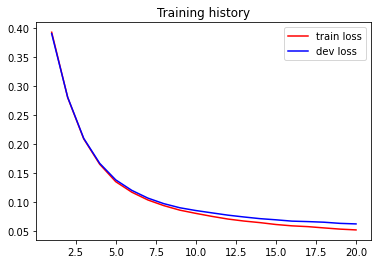

In [68]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [69]:
test_loss, test_acc = global_net.evaluate(test_dataset)
print(f"test loss is: {test_loss}, test accuracy is: {test_acc}")

test loss is: 0.049441803246736526, test accuracy is: 0.9856606125831604


## Adam:

In [70]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size, opt=torch.optim.Adam)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [71]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.4694, Accuracy = 0.8587
client_1: Loss = 0.4653, Accuracy = 0.8574
client_2: Loss = 0.4623, Accuracy = 0.8618
client_3: Loss = 0.4595, Accuracy = 0.86
client_4: Loss = 0.4725, Accuracy = 0.8563
client_5: Loss = 0.4555, Accuracy = 0.8668
client_6: Loss = 0.4706, Accuracy = 0.861
client_7: Loss = 0.4643, Accuracy = 0.8562
After round 1, train_loss = 0.3925, dev_loss = 0.3904, dev_acc = 0.8876

Start Round 2 ...
client_0: Loss = 0.306, Accuracy = 0.9094
client_1: Loss = 0.2978, Accuracy = 0.9095
client_2: Loss = 0.2973, Accuracy = 0.9113
client_3: Loss = 0.2962, Accuracy = 0.9082
client_4: Loss = 0.3052, Accuracy = 0.9123
client_5: Loss = 0.2942, Accuracy = 0.9148
client_6: Loss = 0.3035, Accuracy = 0.915
client_7: Loss = 0.29, Accuracy = 0.9162
After round 2, train_loss = 0.2739, dev_loss = 0.2741, dev_acc = 0.9205

Start Round 3 ...
client_0: Loss = 0.2294, Accuracy = 0.935
client_1: Loss = 0.2183, Accuracy = 0.9366
client_2: Loss = 0.2235, Accuracy 

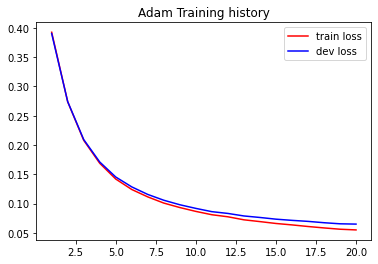

In [72]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Adam Training history')
plt.show()

In [73]:
test_loss, test_acc = global_net.evaluate(test_dataset)
print(f"test loss is: {test_loss}, test accuracy is: {test_acc}")

test loss is: 0.051976196467876434, test accuracy is: 0.9832871556282043


## Non-iid

In [74]:
def partition_by_class(dataset: IterableDataset):
    key = lambda x: x[1]
    return {k:list(vs) for k,vs in groupby(sorted(dataset,key=key), key)}

def split(partition, nb_nodes: int, alpha: float = 1.):
    splitter = Dirichlet(torch.ones(nb_nodes)*alpha)
    nodes = [list() for i in range(nb_nodes)]
    
    # iterate class and add a random nb of samples to each node
    for k,vs in partition.items():
        random.shuffle(vs)
        
        nbs = splitter.sample() * len(vs)
        indices = torch.cat((torch.zeros(1),nbs.cumsum(0).round()),0).long()
        
        for i,(start,stop) in enumerate(zip(indices[:-1],indices[1:])):
            nodes[i] += vs[start:stop]
    return nodes
    
partition = partition_by_class(train_dataset)

print(f"total # of samples : {len(train_dataset)}")
for k,v in partition.items():
    print(f" - class {k} : {len(v)}")



total # of samples : 49800
 - class 0 : 4918
 - class 1 : 5589
 - class 2 : 4973
 - class 3 : 5036
 - class 4 : 4851
 - class 5 : 4539
 - class 6 : 4931
 - class 7 : 5191
 - class 8 : 4842
 - class 9 : 4930


In [75]:
nodes = split(partition,num_clients,alpha=0.1)
for i,n in enumerate(nodes):
    print(f"node {i} :")
    for k,vs in partition_by_class(n).items():
        print(f" - class {k} : {len(vs)}")
    print(f"TOTAL      : {len(n)}\n")

node 0 :
 - class 0 : 43
 - class 2 : 12
 - class 3 : 2107
 - class 4 : 2
 - class 5 : 4049
 - class 7 : 3797
 - class 8 : 35
 - class 9 : 1527
TOTAL      : 11572

node 1 :
 - class 0 : 3
 - class 2 : 1
 - class 4 : 1
 - class 6 : 1
 - class 7 : 1391
 - class 8 : 161
 - class 9 : 1248
TOTAL      : 2806

node 2 :
 - class 0 : 172
 - class 1 : 417
 - class 2 : 4389
 - class 5 : 19
 - class 6 : 2684
 - class 7 : 1
 - class 8 : 65
 - class 9 : 565
TOTAL      : 8312

node 3 :
 - class 0 : 4643
 - class 1 : 4562
 - class 2 : 571
 - class 3 : 2924
 - class 7 : 1
 - class 9 : 2
TOTAL      : 12703

node 4 :
 - class 1 : 558
 - class 3 : 5
 - class 5 : 157
 - class 6 : 1301
 - class 8 : 4425
 - class 9 : 1584
TOTAL      : 8030

node 5 :
 - class 0 : 50
 - class 1 : 52
 - class 5 : 306
 - class 6 : 945
 - class 7 : 1
TOTAL      : 1354

node 6 :
 - class 0 : 7
 - class 4 : 510
 - class 8 : 1
 - class 9 : 2
TOTAL      : 520

node 7 :
 - class 4 : 4338
 - class 5 : 8
 - class 8 : 155
 - class 9 : 2


In [76]:
client_datasets = nodes
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

## Simple SGD:

In [77]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size, opt=torch.optim.SGD)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [78]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss, test_loss))

Start Round 1 ...
client_0: Loss = 0.1368, Accuracy = 0.9584
client_1: Loss = 0.2194, Accuracy = 0.9249
client_2: Loss = 0.033, Accuracy = 0.9898
client_3: Loss = 0.0387, Accuracy = 0.9874
client_4: Loss = 0.0741, Accuracy = 0.9772
client_5: Loss = 0.0943, Accuracy = 0.978
client_6: Loss = 0.2215, Accuracy = 0.9609
client_7: Loss = 0.0321, Accuracy = 0.9916
After round 1, train_loss = 2.3116, dev_loss = 2.309, dev_acc = 0.1251, test_loss = 0.052, test_acc = 0.9833

Start Round 2 ...
client_0: Loss = 0.0639, Accuracy = 0.9797
client_1: Loss = 0.0835, Accuracy = 0.9743
client_2: Loss = 0.0554, Accuracy = 0.9839
client_3: Loss = 0.0341, Accuracy = 0.9895
client_4: Loss = 0.0484, Accuracy = 0.9852
client_5: Loss = 0.2035, Accuracy = 0.9323
client_6: Loss = 2.0544, Accuracy = 0.9609
client_7: Loss = 0.5296, Accuracy = 0.9642
After round 2, train_loss = 1.8862, dev_loss = 1.8704, dev_acc = 0.5772, test_loss = 0.052, test_acc = 0.9833

Start Round 3 ...
client_0: Loss = 0.0493, Accuracy = 0.9

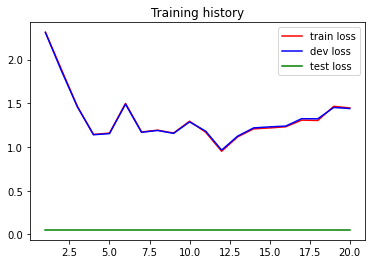

In [79]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [80]:
test_loss, test_acc = global_net.evaluate(test_dataset)
print(f"test loss is: {test_loss}, test accuracy is: {test_acc}")

test loss is: 1.4952481985092163, test accuracy is: 0.8482001423835754


## Adam

In [81]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size, opt=torch.optim.Adam)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

In [82]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}, test_loss = {}, test_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss, test_loss))

Start Round 1 ...
client_0: Loss = 0.0788, Accuracy = 0.9752
client_1: Loss = 0.1446, Accuracy = 0.9593
client_2: Loss = 1.1789, Accuracy = 0.528
client_3: Loss = 0.0303, Accuracy = 0.9898
client_4: Loss = 0.0435, Accuracy = 0.9859
client_5: Loss = 0.1756, Accuracy = 0.9532
client_6: Loss = 0.1801, Accuracy = 0.9844
client_7: Loss = 0.019, Accuracy = 0.995
After round 1, train_loss = 2.3027, dev_loss = 2.3027, dev_acc = 0.0999, test_loss = 0.8482, test_acc = 0.8482

Start Round 2 ...
client_0: Loss = 1.3823, Accuracy = 0.3502
client_1: Loss = 0.1912, Accuracy = 0.9412
client_2: Loss = 0.0357, Accuracy = 0.991
client_3: Loss = 1.2198, Accuracy = 0.3557
client_4: Loss = 0.0953, Accuracy = 0.9733
client_5: Loss = 0.4016, Accuracy = 0.8446
client_6: Loss = 1.9855, Accuracy = 0.9844
client_7: Loss = 0.5122, Accuracy = 0.9642
After round 2, train_loss = 2.4747, dev_loss = 2.4682, dev_acc = 0.1128, test_loss = 0.8482, test_acc = 0.8482

Start Round 3 ...
client_0: Loss = 0.0764, Accuracy = 0.

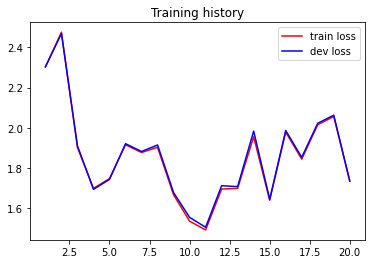

In [83]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [84]:
test_loss, test_acc = global_net.evaluate(test_dataset)
print(f"test loss is: {test_loss}, test accuracy is: {test_acc}")

test loss is: 1.6983309984207153, test accuracy is: 0.8057753443717957
